In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score, davies_bouldin_score

In [2]:
df = pd.read_csv('/content/customer_features_scaled.csv')
df.head(10)

,CustomerID,Sum_Quantity,Mean_UnitPrice,Mean_TotalPrice,Sum_TotalPrice,Count_Invoice,Count_Stock,Mean_InvoiceCountPerStock,Mean_StockCountPerInvoice,Mean_UnitPriceMeanPerInvoice,Mean_QuantitySumPerInvoice,Mean_TotalPriceMeanPerInvoice,Mean_TotalPriceSumPerInvoice,Mean_UnitPriceMeanPerStock,Mean_QuantitySumPerStock,Mean_TotalPriceMeanPerStock,Mean_TotalPriceSumPerStock
0,000nan,4.984467,1.506343,-0.268408,4.595722,2.432481,4.773105,2.067962,2.330682,3.094080,0.761335,0.914696,2.100059,2.332104,1.979686,-0.076864,2.392380
1,012346,3.789233,-2.120154,3.800623,3.161700,-1.158633,-2.296006,-1.015864,-2.307499,-2.100457,8.847780,3.719362,7.377665,-2.141668,3.384916,3.763263,3.337067
2,012747,0.879252,0.879583,1.007144,1.397472,1.532615,0.156943,1.957285,-0.614124,0.749921,-0.306106,0.973710,0.485241,1.078802,1.041469,0.667948,1.526344
3,012748,3.038005,-0.106556,-1.068898,2.706127,2.352800,3.983682,1.982065,0.343236,1.872665,-0.238979,-0.080428,-0.710410,-0.049208,0.348309,-0.892187,-0.000881
4,012749,0.982814,1.125208,0.282588,1.379978,0.890138,1.397000,0.537992,1.095989,1.056342,0.756329,0.259518,1.527988,1.056653,-0.159892,0.290885,0.329836
5,012820,0.466642,-0.817031,-0.019920,0.296923,0.656870,0.395429,-0.412569,-0.123289,-0.824860,0.189404,-0.105017,-0.181951,-0.935154,0.238579,0.003600,-0.128951
6,012821,-1.233887,-0.235351,-0.060898,-1.725684,-1.158633,-1.361354,-1.015864,-1.051000,-0.261189,-0.848867,-0.151699,-1.489691,-0.233985,0.110322,-0.025617,-0.255883
7,012822,0.268811,-0.078187,0.286568,0.302366,-0.198605,0.135925,-0.081936,0.397982,-0.164225,0.676729,0.348066,0.785080,-0.141162,0.261716,0.260265,0.220589
8,012823,-0.366422,1.825216,2.528634,0.774998,0.890138,-2.296006,2.064151,-2.307499,1.669397,-1.283030,2.429015,0.374043,1.836621,2.299290,2.554670,2.796227
9,012824,-0.360106,-0.204132,-0.026684,-0.409951,-1.158633,-0.284543,-1.015864,0.500258,-0.231237,0.478007,-0.117808,0.540661,-0.202481,-0.149025,0.009031,-0.221666


In [3]:
X = df.drop(columns=['CustomerID'])

Quy tắc khi chọn MinPts
| Quy tắc                       | Khi dùng      |
| ----------------------------- | ------------- |
| MinPts ≥ dim + 1              | cơ bản        |
| MinPts = 2 × dim              | phổ biến nhất |
| MinPts = 4 × dim              | dữ liệu nhiễu |
| MinPts = max(5, 2×dim)        | an toàn nhất  |
| Tăng MinPts theo size dataset | dữ liệu lớn   |


Quy tắc chọn eps:

1️⃣ Dùng K-distance plot để tìm elbow → chuẩn nhất

2️⃣ eps phải phản ánh mật độ thực của dữ liệu

3️⃣ eps phải áp dụng cho dữ liệu đã scale

4️⃣ MinPts tăng → eps tăng tương ứng

5️⃣ noise khoảng 10-30% là đẹp

6️⃣ eps không dựa cảm tính, phải dựa trên đồ thị

7️⃣ eps ≈ median(k-distance) (phụ trợ)

8️⃣ eps phụ thuộc vào số chiều

9️⃣ eps không quá nhỏ cũng không quá lớn

🔟 eps cuối cùng phải kiểm tra lại bằng trực quan (2D/3D)

In [4]:
from sklearn.decomposition import PCA

pca = PCA(n_components=5)   # hoặc 2, 3, 10
X_pca = pca.fit_transform(X)
print("X_pca shape:", X_pca.shape)
print("Số chiều sau PCA:", X_pca.shape[1])


X_pca shape: (3921, 5)
Số chiều sau PCA: 5


In [5]:
def compute_eps_elbow(X, min_samples):
    """
    Tính eps tối ưu bằng k-distance elbow
    """
    n_samples = X.shape[0]
    k = max(min_samples - 1, 1)
    n_neighbors = min(k + 1, n_samples)

    if n_neighbors < 2:
        return None

    nbrs = NearestNeighbors(n_neighbors=n_neighbors).fit(X)
    distances, _ = nbrs.kneighbors(X)

    k_index = min(k, distances.shape[1] - 1)
    k_distances = np.sort(distances[:, k_index])

    # Elbow hình học
    n_points = len(k_distances)
    all_points = np.vstack((np.arange(n_points), k_distances)).T

    first_point = all_points[0]
    last_point = all_points[-1]
    line_vec = last_point - first_point
    norm = np.linalg.norm(line_vec)

    if norm == 0:
        return float(k_distances[-1])

    line_vec_norm = line_vec / norm
    vec_from_first = all_points - first_point
    scalar_proj = np.dot(vec_from_first, line_vec_norm)
    proj = np.outer(scalar_proj, line_vec_norm)
    vec_to_line = vec_from_first - proj
    dist_to_line = np.linalg.norm(vec_to_line, axis=1)

    elbow_index = np.argmax(dist_to_line)
    eps_opt = float(k_distances[elbow_index])

    return eps_opt

In [6]:
def run_dbscan_with_metrics(X, eps, min_samples, min_cluster_points=10):
    model = DBSCAN(eps=eps, min_samples=min_samples)
    labels = model.fit_predict(X)

    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    noise_rate = np.mean(labels == -1)

    mask = labels != -1
    if len(np.unique(labels[mask])) > 1 and np.sum(mask) >= min_cluster_points:
        sil = silhouette_score(X[mask], labels[mask])
        dbi = davies_bouldin_score(X[mask], labels[mask])
    else:
        sil, dbi = None, None

    return labels, n_clusters, noise_rate, sil, dbi


In [7]:
min_samples_values = [5,6,7, 8, 9, 10, 11, 12, 13, 14, 15]

results = []
labels_dict = {}

for ms in min_samples_values:
    eps = compute_eps_elbow(X_pca, ms)

    labels, n_clusters, noise_rate, sil, dbi = run_dbscan_with_metrics(
        X_pca, eps, ms
    )

    labels_dict[ms] = labels

    results.append({
        "min_samples": ms,
        "eps_optimal": eps,
        "n_clusters": n_clusters,
        "noise_rate": noise_rate,
        "silhouette": sil,
        "dbi": dbi
    })

    print(f"✓ min_samples={ms:>2} | eps={eps:.5f} | clusters={n_clusters} | noise={noise_rate:.2%}")


✓ min_samples= 5 | eps=1.59608 | clusters=3 | noise=4.13%
✓ min_samples= 6 | eps=1.71483 | clusters=2 | noise=3.55%
✓ min_samples= 7 | eps=1.80340 | clusters=1 | noise=3.09%
✓ min_samples= 8 | eps=1.86668 | clusters=1 | noise=3.03%
✓ min_samples= 9 | eps=1.86668 | clusters=1 | noise=3.29%
✓ min_samples=10 | eps=1.89239 | clusters=1 | noise=3.52%
✓ min_samples=11 | eps=1.96214 | clusters=1 | noise=3.44%
✓ min_samples=12 | eps=2.01372 | clusters=1 | noise=3.29%
✓ min_samples=13 | eps=2.03858 | clusters=1 | noise=3.19%
✓ min_samples=14 | eps=2.06280 | clusters=1 | noise=3.16%
✓ min_samples=15 | eps=2.11351 | clusters=1 | noise=3.01%


In [8]:
df_results = pd.DataFrame(results)

df_results.sort_values(
    by=["n_clusters", "noise_rate"],
    ascending=[False, True]
)


,min_samples,eps_optimal,n_clusters,noise_rate,silhouette,dbi
0,5,1.596081,3,0.041316,0.362467,0.522043
1,6,1.714826,2,0.035450,0.366018,0.590910
10,15,2.113509,1,0.030094,NaN,NaN
3,8,1.866680,1,0.030349,NaN,NaN
2,7,1.803405,1,0.030859,NaN,NaN
9,14,2.062802,1,0.031625,NaN,NaN
8,13,2.038584,1,0.031880,NaN,NaN
4,9,1.866680,1,0.032900,NaN,NaN
7,12,2.013725,1,0.032900,NaN,NaN
6,11,1.962139,1,0.034430,NaN,NaN


| Silhouette      | Ý nghĩa                                             |
| --------------- | --------------------------------------------------- |
| **0.50 – 1.0**  | Các cụm rất rõ ràng, tách biệt tốt                  |
| **0.25 – 0.50** | Các cụm ổn, khá rõ                                  |
| **0.10 – 0.25** | Các cụm yếu → hơi bị lẫn nhau                       |
| **0 – 0.10**    | Các cụm không rõ ràng                               |
| **< 0**         | phân cụm sai → điểm nằm gần cụm khác hơn cụm của nó |

| DBI           | Ý nghĩa                      |
| ------------- | ---------------------------- |
| **0.0 – 0.6** | cụm rất rõ ràng              |
| **0.6 – 1.0** | cụm tốt                      |
| **1.0 – 1.5** | cụm yếu, lẫn nhau            |
| **> 1.5**     | phân cụm tệ                  |
| **> 2.0**     | gần như không có cụm thực sự |

In [15]:
eps_final=compute_eps_elbow(X,5)
model = DBSCAN(eps=eps_final, min_samples=5)
labels = model.fit_predict(X_pca)

In [16]:
df_dbscan = df.copy()
df_dbscan["cluster"] = labels

In [17]:
df_dbscan["cluster"].value_counts().sort_index()


,count
cluster,
-1,102
0,3813
1,6


In [18]:
for c in sorted(df_dbscan["cluster"].unique()):
    print(f"\n================ CLUSTER {c} =================")
    print(df_dbscan[df_dbscan["cluster"] == c])


================ CLUSTER -1 =================
     CustomerID  Sum_Quantity  Mean_UnitPrice  Mean_TotalPrice  \
0        000nan      4.984467        1.506343        -0.268408   
1        012346      3.789233       -2.120154         3.800623   
3        012748      3.038005       -0.106556        -1.068898   
29       012847      0.633895       -1.582172        -0.690888   
45       012875      1.211861       -4.826446         2.129732   
...         ...           ...             ...              ...   
3774     018087      1.688062        4.385474         3.192853   
3784     018102      3.685813        0.936006         2.773208   
3807     018133      0.920657       -2.936582         2.942897   
3811     018139      1.941434       -1.323192         1.251723   
3897     018251      2.187001       -2.722548         2.391220   

      Sum_TotalPrice  Count_Invoice  Count_Stock  Mean_InvoiceCountPerStock  \
0           4.595722       2.432481     4.773105                   2.067962   
1 

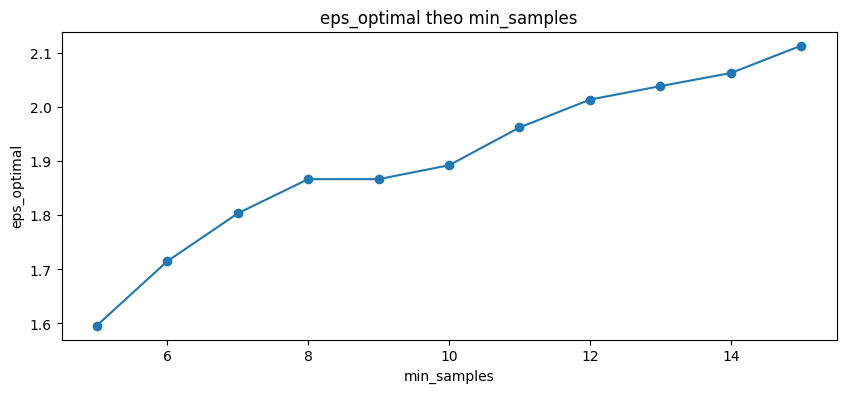

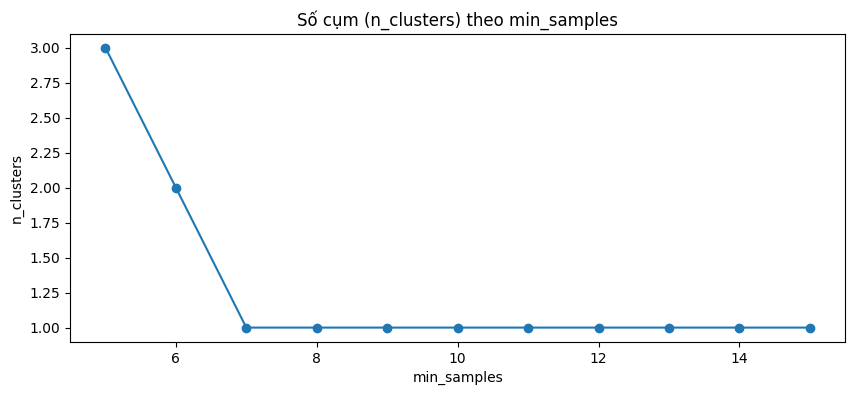

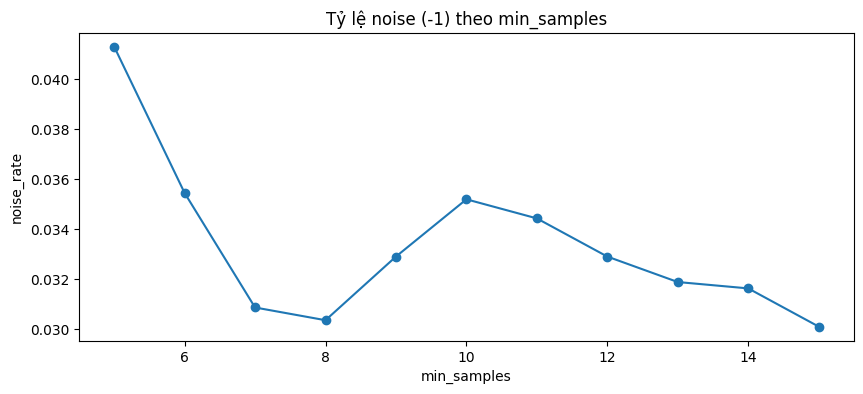

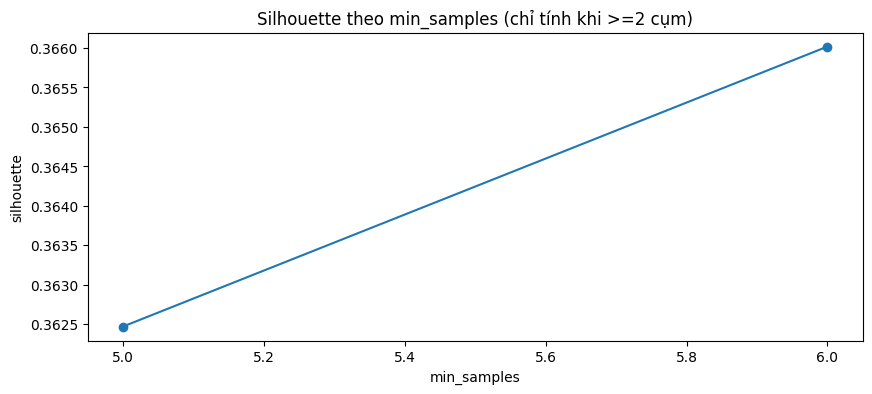

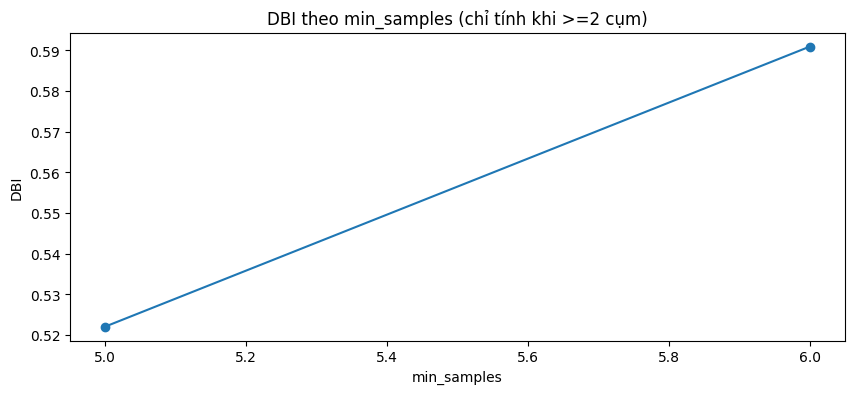

In [20]:
import matplotlib.pyplot as plt

x = df_results["min_samples"].values

plt.figure(figsize=(10,4))
plt.plot(x, df_results["eps_optimal"].values, marker="o")
plt.title("eps_optimal theo min_samples")
plt.xlabel("min_samples")
plt.ylabel("eps_optimal")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(x, df_results["n_clusters"].values, marker="o")
plt.title("Số cụm (n_clusters) theo min_samples")
plt.xlabel("min_samples")
plt.ylabel("n_clusters")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(x, df_results["noise_rate"].values, marker="o")
plt.title("Tỷ lệ noise (-1) theo min_samples")
plt.xlabel("min_samples")
plt.ylabel("noise_rate")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(x, df_results["silhouette"].values, marker="o")
plt.title("Silhouette theo min_samples (chỉ tính khi >=2 cụm)")
plt.xlabel("min_samples")
plt.ylabel("silhouette")
plt.show()

plt.figure(figsize=(10,4))
plt.plot(x, df_results["dbi"].values, marker="o")
plt.title("DBI theo min_samples (chỉ tính khi >=2 cụm)")
plt.xlabel("min_samples")
plt.ylabel("DBI")
plt.show()
